# Bulldozer Sale Price Prediction
## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. Check data/bluebook-for-bulldozers/Data Dictionary.xlsx

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy, pandas as pd, seaborn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Import Train+Validation dataset
data = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", parse_dates=["saledate"], low_memory=False)
data.sort_values(by=["saledate"], inplace=True)
data.info()
#data.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')


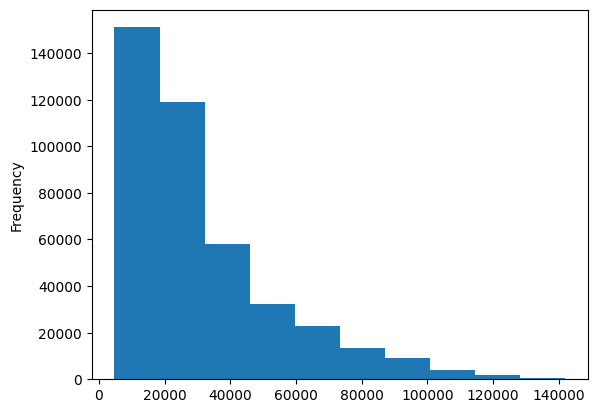

In [101]:
print(data.columns)
data.SalePrice.plot.hist();

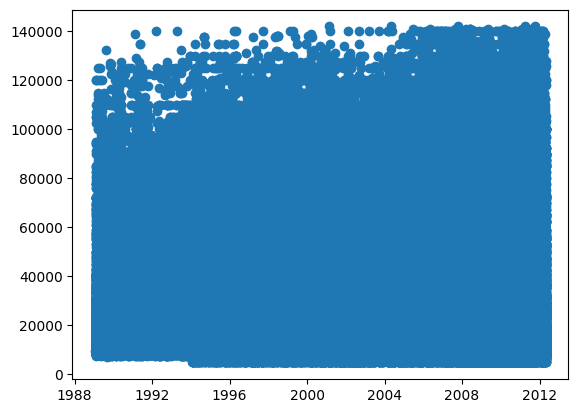

In [102]:
fig, ax = plt.subplots()
ax.scatter(data.saledate, data.SalePrice);

In [103]:
# saledate is a pandas Series of datetime propery
print(f"saledate dtype: {data.saledate.dtype}")
print("\nsaledate info:")
data.saledate.info()
print(f"\nsaledate describe:")
print(data.saledate.describe())
data.state.value_counts()

saledate dtype: datetime64[ns]

saledate info:
<class 'pandas.core.series.Series'>
Index: 412698 entries, 205615 to 409203
Series name: saledate
Non-Null Count   Dtype         
--------------   -----         
412698 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 6.3 MB

saledate describe:
count                           412698
mean     2004-10-19 01:54:17.182733952
min                1989-01-17 00:00:00
25%                2000-12-06 00:00:00
50%                2006-06-28 00:00:00
75%                2009-05-28 00:00:00
max                2012-04-28 00:00:00
Name: saledate, dtype: object


state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

In [135]:
def ProcessData(data: pd.DataFrame) -> None:
    """
    (1) Remove Timestamp dtype. model.fit() hits "TypeError: Cannot cast DatetimeArray to dtype float32" due to this datetime dtype of 'saledata'
    (2) Extract information from Timestamp dtype into individual columns
    (3) Convert object dtype into Category
    (4) Fill NULL / N.A missing data
    Input:
    data - Train, Cross-validation OR Test datasets. Don't mix and match or combine them as this will affect the performance of the model.
    """
    data["saleYear"] = data.saledate.dt.year
    data["saleMonth"] = data.saledate.dt.month
    data["saleDay"] = data.saledate.dt.day
    data["saleDayOfWeek"] = data.saledate.dt.dayofweek
    data["saleDayOfYear"] = data.saledate.dt.dayofyear

    # model.fit() hits "TypeError: Cannot cast DatetimeArray to dtype float32" due to this datetime dtype of 'saledata'
    # Now we've enriched our DataFrame with date time features, we can remove 'saledate'
    data.drop("saledate", axis=1, inplace=True)

    # Convert object dtype to category dtype
    for k,v in data.items():
        # v is Series
        if pd.api.types.is_object_dtype(v):
            # Assign a numerical value to each category
            # NULL / N.A will be assigned -1 by default. +1 here will offset all codes by +1. So, Null / N.A will have 0
            if pd.isna(v).sum() or pd.isnull(v).sum():
                data[k] = v.astype("category").cat.codes + 1 # This will assign a numerical value to each category
            else:
                data[k] = v.astype("category").cat.codes
        elif pd.api.types.is_numeric_dtype(v):
            if pd.isna(v).sum() or pd.isnull(v).sum():
                # Fix missing numerical values        
                # Add a flag to mark originally missing value
                data[f"{k}_missing"] = pd.isnull(v)
                # Fill missing values with media (NOT mean as mean is more supceptible to outliers)
                data[k] = v.fillna(v.median()) # XXX: Mixing Train with Cross-Validation and/or Test dataset will affect this value.
                # Fix missing categorical values
            else:
                # Add a flag to mark originally missing value
                data[f"{k}_missing"] = pd.isnull(v)

In [142]:
# Extract January 1, 2012 - April 30, 2012 to a validation dataset
data_train = data[data.saledate.dt.year != 2012]
ProcessData(data_train)
print(f"{len(data_train)} data_train")

data_validation = data[data.saledate.dt.year == 2012]
ProcessData(data_validation)
print(f"{len(data_validation)} data_validation")

X_train = data_train.drop("SalePrice", axis=1)
Y_train = data_train.SalePrice

X_validation = data_validation.drop("SalePrice", axis=1)
Y_validation = data_validation.SalePrice

X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape
X_train.info()
assert 0 == X_train.isna().sum().all()

/tmp/ipykernel_58272/2226696208.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["saleYear"] = data.saledate.dt.year
/tmp/ipykernel_58272/2226696208.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["saleMonth"] = data.saledate.dt.month
/tmp/ipykernel_58272/2226696208.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

401125 data_train
11573 data_validation
<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 393123
Data columns (total 69 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   SalesID                           401125 non-null  int64  
 1   MachineID                         401125 non-null  int64  
 2   ModelID                           401125 non-null  int64  
 3   datasource                        401125 non-null  int64  
 4   auctioneerID                      401125 non-null  float64
 5   YearMade                          401125 non-null  int64  
 6   MachineHoursCurrentMeter          401125 non-null  float64
 7   UsageBand                         401125 non-null  int8   
 8   fiModelDesc                       401125 non-null  int16  
 9   fiBaseModel                       401125 non-null  int16  
 10  fiSecondaryDesc                   401125 non-null  int16  
 11  fiModelSerie

/tmp/ipykernel_58272/2226696208.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[k] = v.astype("category").cat.codes + 1 # This will assign a numerical value to each category
/tmp/ipykernel_58272/2226696208.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[k] = v.astype("category").cat.codes + 1 # This will assign a numerical value to each category
/tmp/ipykernel_58272/2226696208.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [137]:
# Save preprocessed data so far into csv
X_train.to_csv("data/bluebook-for-bulldozers/Train_processed.csv", index=False)

In [151]:
# The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
def rmsle(truth, prediction):
    return numpy.sqrt(mean_squared_log_error(truth, prediction))

def Evaluate(model, train_features, train_labels, validation_features, validation_labels):
    train_predictions = model.predict(train_features)
    #print(f"\nTraining predictions: {train_predictions}")
    validation_predictions = model.predict(validation_features)
    #print(f"\nValidation predictions: {validation_predictions}")
    scores = {
        "Train R^2": r2_score(train_labels, train_predictions),
        "Validation R^2": r2_score(validation_labels, validation_predictions),
        "Train MAE": mean_absolute_error(train_labels, train_predictions),
        "Validation MAE": mean_absolute_error(validation_labels, validation_predictions),
        "Train RMSLE": None if (train_predictions <= -1).any() else rmsle(train_labels, train_predictions), # metrics requirement of the competition
        "Validation RMSLE": None if (validation_predictions <= -1).any() else rmsle(validation_labels, validation_predictions) # metrics requirement of the competition
    }
    return scores

In [154]:
# 412698 rows in the dataset. Set max_samples to reduce training time and speed up experiment cycles. n_jobs defaults to None which means 1.
model = LinearRegression(n_jobs=-1)
model.fit(X_train, Y_train)
scores = Evaluate(model, X_train, Y_train, X_validation, Y_validation)
print("Linear Regression scores:")
scores

Linear Regression scores:


{'Train R^2': 0.420253145444343,
 'Validation R^2': 0.35732093063053405,
 'Train MAE': 12516.449578884349,
 'Validation MAE': 14907.070510902035,
 'Train RMSLE': None,
 'Validation RMSLE': None}

In [155]:
model = RandomForestRegressor(n_jobs=-1) # 412698 rows in the dataset. Set max_samples to reduce training time and speed up experiment cycles. n_jobs defaults to None which means 1.
model.fit(X_train, Y_train)
scores = Evaluate(model, X_train, Y_train, X_validation, Y_validation)
print("RandomForestRegressor scores:")
scores

RandomForestRegressor scores:


{'Train R^2': 0.9875364254474083,
 'Validation R^2': 0.4863351174032302,
 'Train MAE': 1578.4033986662512,
 'Validation MAE': 11111.293375961288,
 'Train RMSLE': np.float64(0.08422504280848148),
 'Validation RMSLE': np.float64(0.49285833423496644)}

In [146]:
# Hyperparameter tuning using RandomizedSearchCV
params = {"n_estimators": numpy.arange(10, 1000, 20),
            "max_depth": [None, 7, 11, 13, 17, 19],
            "min_samples_split": numpy.arange(1, 20, 2),
            "min_samples_leaf": numpy.arange(1, 20, 2),
            "max_features": [0.5, 1, "sqrt", "auto"],
            "max_samples": [100000, 200000, 250000]
        }
print(f"Baseline model scores: {scores}")
print("=== RandomForestRegressor ===")
random_forest_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1), param_distributions=params, cv=5, n_iter=25,verbose=True)
random_forest_model.fit(X_train, Y_train)
print(f"Best params : {random_forest_model.best_params_}")
print(f"Score: {random_forest_model.score(X_validation, Y_validation)}")

Baseline model scores: {'Train R^2': 0.9875295913834697, 'Validation R^2': 0.4927078851582598, 'Train MAE': 1578.8372838142725, 'Validation MAE': 11080.54301218353, 'Train RMSLE': np.float64(0.08423354524661288), 'Validation RMSLE': np.float64(0.49042906970088257)}
=== RandomForestRegressor ===
Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

In [100]:
# Use the test dataset
test_data = pd.read_csv("data/bluebook-for-bulldozers/Test.csv", parse_dates=["saledate"])
test_data.sort_values(by=["saledate"], inplace=True)
ProcessData(test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12457 entries, 1408 to 9803
Data columns (total 68 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SalesID                           12457 non-null  int64  
 1   MachineID                         12457 non-null  int64  
 2   ModelID                           12457 non-null  int64  
 3   datasource                        12457 non-null  int64  
 4   auctioneerID                      12457 non-null  int64  
 5   YearMade                          12457 non-null  int64  
 6   MachineHoursCurrentMeter          12457 non-null  float64
 7   UsageBand                         12457 non-null  int8   
 8   fiModelDesc                       12457 non-null  int16  
 9   fiBaseModel                       12457 non-null  int16  
 10  fiSecondaryDesc                   12457 non-null  int8   
 11  fiModelSeries                     12457 non-null  int8   
 12  fiModel

In [101]:
X_train.info()
# Find the differences in feature set between train and test dataset
# If <foo>_missing column(s) is absent from test_data, it means the <foo> column in test_data does not have NULL / N.A
missing = set(X_train.columns) - set(test_data.columns)
print(f"\nColumns missing from test_data: {missing}")
for i in missing:
    if "_missing" in i:
        test_data[i] = False
    else:
        raise ValueError(f"Unexpected missing column {i} from test dataset!")
missing = set(X_train.columns) - set(test_data.columns)
assert 0 == len(missing)

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 393123
Data columns (total 69 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   SalesID                           401125 non-null  int64  
 1   MachineID                         401125 non-null  int64  
 2   ModelID                           401125 non-null  int64  
 3   datasource                        401125 non-null  int64  
 4   auctioneerID                      401125 non-null  float64
 5   YearMade                          401125 non-null  int64  
 6   MachineHoursCurrentMeter          401125 non-null  float64
 7   UsageBand                         401125 non-null  int8   
 8   fiModelDesc                       401125 non-null  int16  
 9   fiBaseModel                       401125 non-null  int16  
 10  fiSecondaryDesc                   401125 non-null  int16  
 11  fiModelSeries                     401125 non-null  i

## Feature Importance
### Which feature(s) contribute most to the outcomes of the model and how?

In [102]:
def CorrelationMatrixHeatMap(df : pd.DataFrame):
    matrix = df.corr()
    fig, ax = plt.subplots(figsize=(15,10))
    ax = seaborn.heatmap(matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu") # https://r02b.github.io/seaborn_palettes/
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) # To avoid the truncation in y-axis
    
def FeatureImportance(columns, metrics, n=25):
    df = pd.DataFrame({
        "Features": columns,
        "Metrics": metrics
    }).sort_values("Metrics", ascending=False, ignore_index=True).reset_index(drop=True)
    fig, ax = plt.subplots()
    ax.barh(df.Features[:n], df.Metrics[:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Metrics")
    ax.set_title("Feature Importance")
    ax.invert_yaxis()

features coefficients: {'SalesID': np.float64(0.0012352725446223652), 'SalePrice': np.float64(-0.006680814923449225), 'MachineID': np.float64(0.1343007085914253), 'ModelID': np.float64(-95.62647733769151), 'datasource': np.float64(-34.94400422934798), 'auctioneerID': np.float64(10.549789539321182), 'YearMade': np.float64(-0.0047047318641659785), 'MachineHoursCurrentMeter': np.float64(1428.8054374859712), 'UsageBand': np.float64(-2.858637207046641), 'saledate': np.float64(7.616444139570092), 'fiModelDesc': np.float64(91.12515121190334), 'fiBaseModel': np.float64(67.13741758665918), 'fiSecondaryDesc': np.float64(116.93630533191845), 'fiModelSeries': np.float64(1294.3583741996651), 'fiModelDescriptor': np.float64(47.49798595810739), 'ProductSize': np.float64(-7.926779551993661), 'fiProductClassDesc': np.float64(2679.1206482219764), 'state': np.float64(2679.1206532783117), 'ProductGroup': np.float64(-1921.1789517643074), 'ProductGroupDesc': np.float64(-308.412949976193), 'Drive_System': np

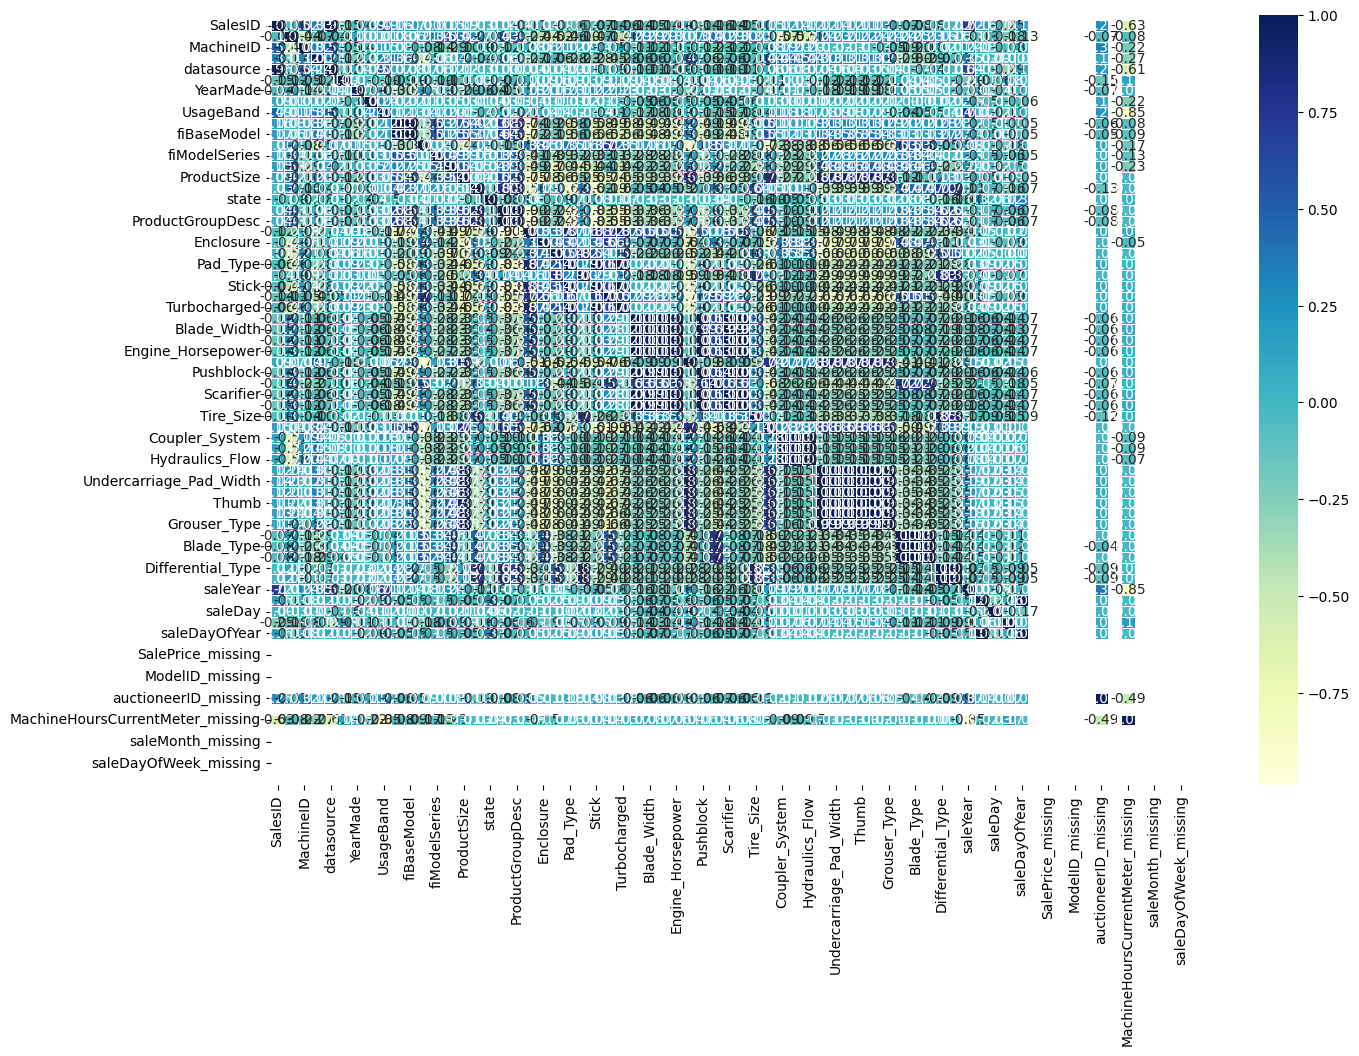

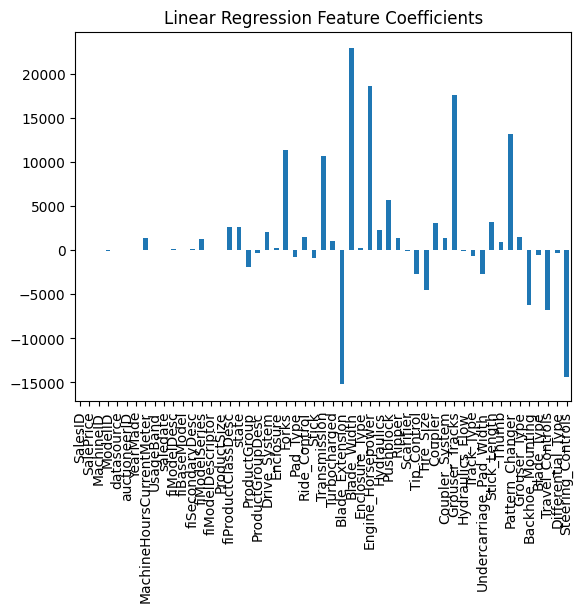

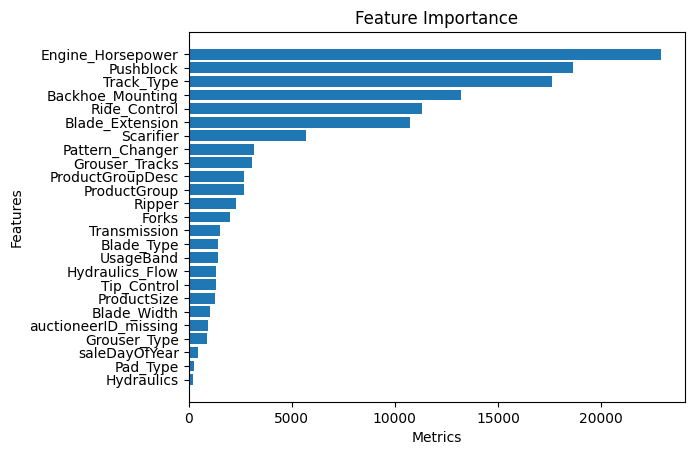

In [ ]:
# Linear Regression
model = LinearRegression(n_jobs=-1)
model.fit(X_train, Y_train)
model.coef_
features = dict(zip(data.columns, list(model.coef_)))
print(f"features coefficients: {features}")
CorrelationMatrixHeatMap(data_train.corr())
features_df = pd.DataFrame(features, index=[0])
features_df.T.plot.bar(title="Linear Regression Feature Coefficients", legend=False)
FeatureImportance(X_train.columns, model.coef_)

features coefficients: {'SalesID': np.float64(0.050090914318345336), 'SalePrice': np.float64(0.01664873581267179), 'MachineID': np.float64(0.03199009643810305), 'ModelID': np.float64(0.0004371083145179595), 'datasource': np.float64(0.004503477782779083), 'auctioneerID': np.float64(0.2618049907962796), 'YearMade': np.float64(0.003280117357028571), 'MachineHoursCurrentMeter': np.float64(0.0012214064693205715), 'UsageBand': np.float64(0.020133058084671265), 'saledate': np.float64(0.08190483889329708), 'fiModelDesc': np.float64(0.051821159395452024), 'fiBaseModel': np.float64(0.00487786847962353), 'fiSecondaryDesc': np.float64(0.004167752693440989), 'fiModelSeries': np.float64(0.23064135457845306), 'fiModelDescriptor': np.float64(0.03917351420925588), 'ProductSize': np.float64(0.008922895284183172), 'fiProductClassDesc': np.float64(0.00038364840142503964), 'state': np.float64(0.00023412857868714603), 'ProductGroup': np.float64(0.0017603200283187943), 'ProductGroupDesc': np.float64(0.008832

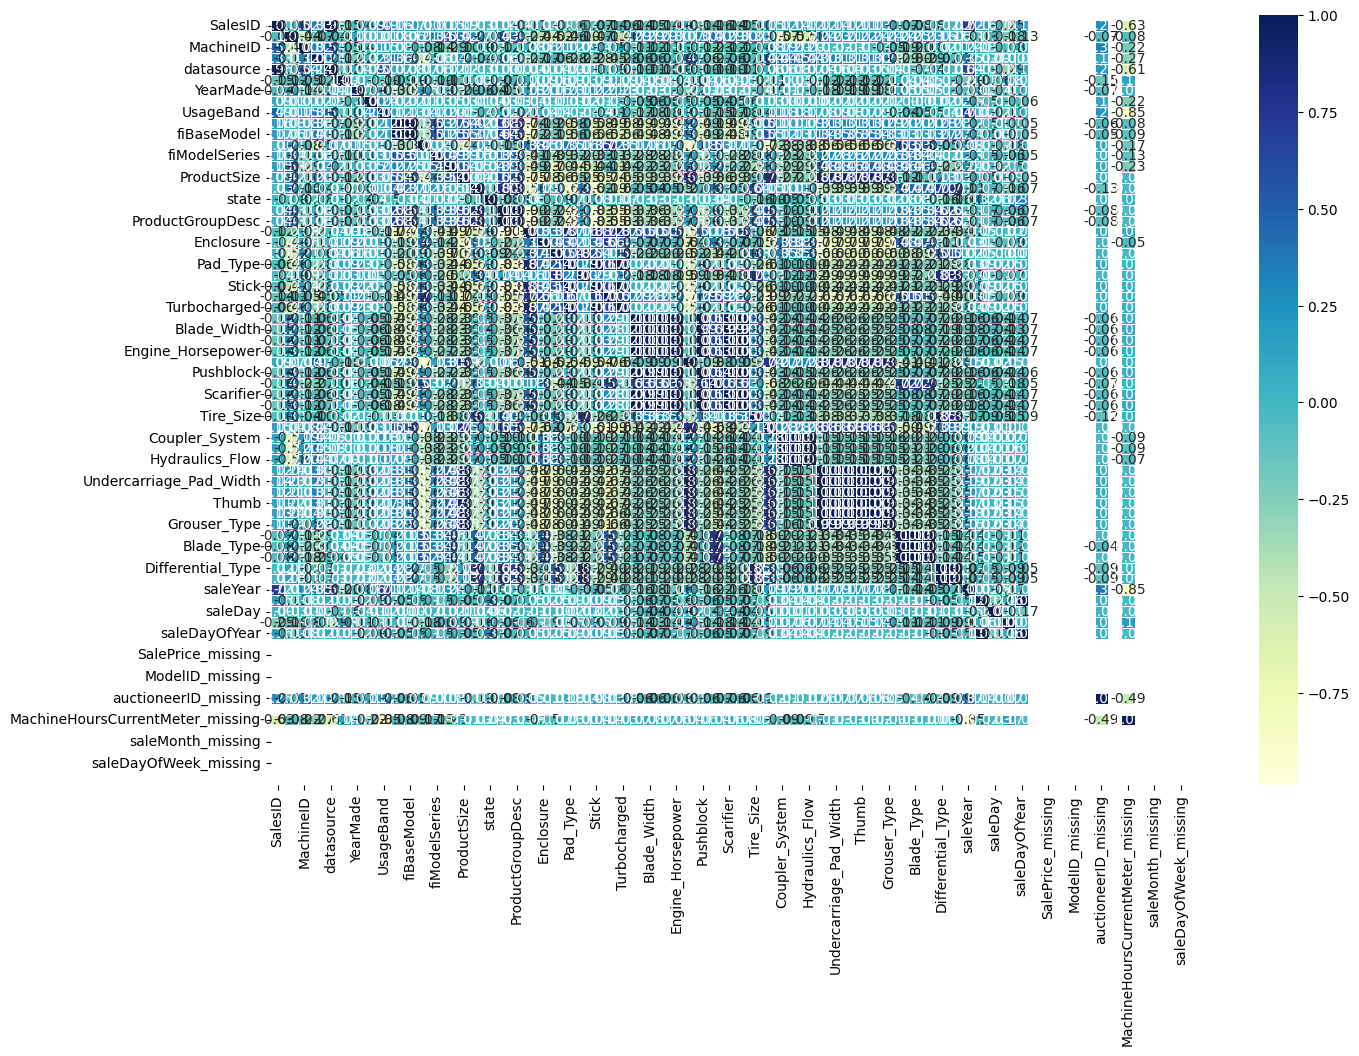

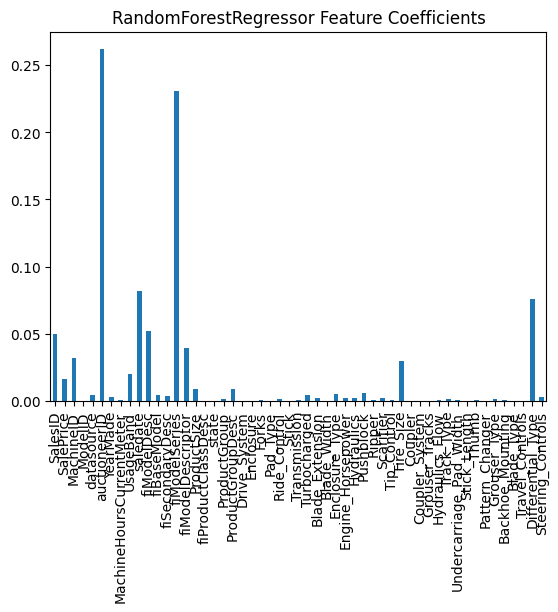

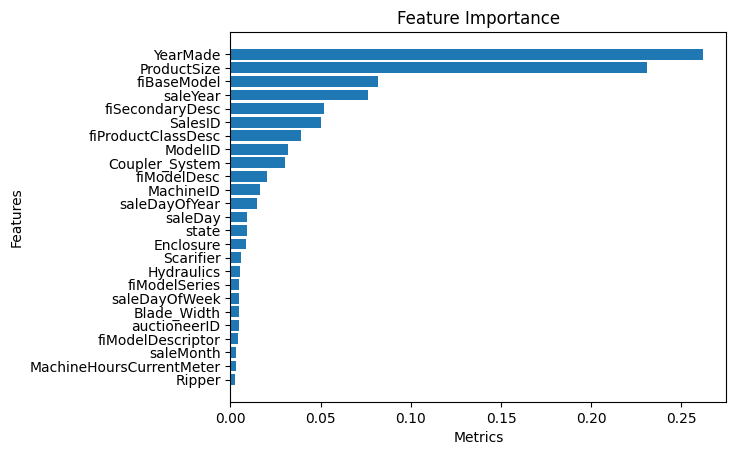

In [106]:
# RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, Y_train)
model.feature_importances_
features = dict(zip(data.columns, list(model.feature_importances_)))
print(f"features coefficients: {features}")
CorrelationMatrixHeatMap(data_train.corr())
features_df = pd.DataFrame(features, index=[0])
features_df.T.plot.bar(title="RandomForestRegressor Feature Coefficients", legend=False)
FeatureImportance(X_train.columns, model.feature_importances_)